In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../data/Bitcoin_sort.csv')
df.head()

,id,CoinDate,CoinOpen,CoinHigh,CoinLow,CoinClose,CoinVolume,CoinCap
0,937,2020/05/04,8895.74,8956.91,8645.02,8912.65,4.571880e+10,1.636545e+11
1,936,2020/05/05,8912.83,9062.41,8856.83,9003.07,4.314846e+10,1.653325e+11
2,935,2020/05/06,9007.44,9411.47,8966.71,9268.76,4.937189e+10,1.702296e+11
3,934,2020/05/07,9261.90,9992.66,9138.32,9951.52,6.111270e+10,1.827874e+11
4,933,2020/05/08,9936.16,9996.74,9767.17,9842.67,5.178075e+10,1.808049e+11


In [3]:
x_date=[]
for i in range(0,938,91):
    x_date.append(df['CoinDate'][i])

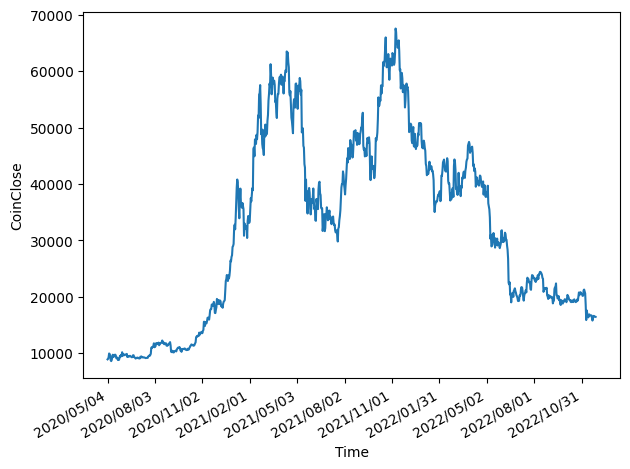

In [4]:
fig, ax = plt.subplots()

ax.plot(df['CoinClose'])
ax.set_xlabel('Time')
ax.set_ylabel('CoinClose')

plt.xticks(np.arange(0,938,91),x_date)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('Bitcoin_figures/peixeiro.png', dpi=300)

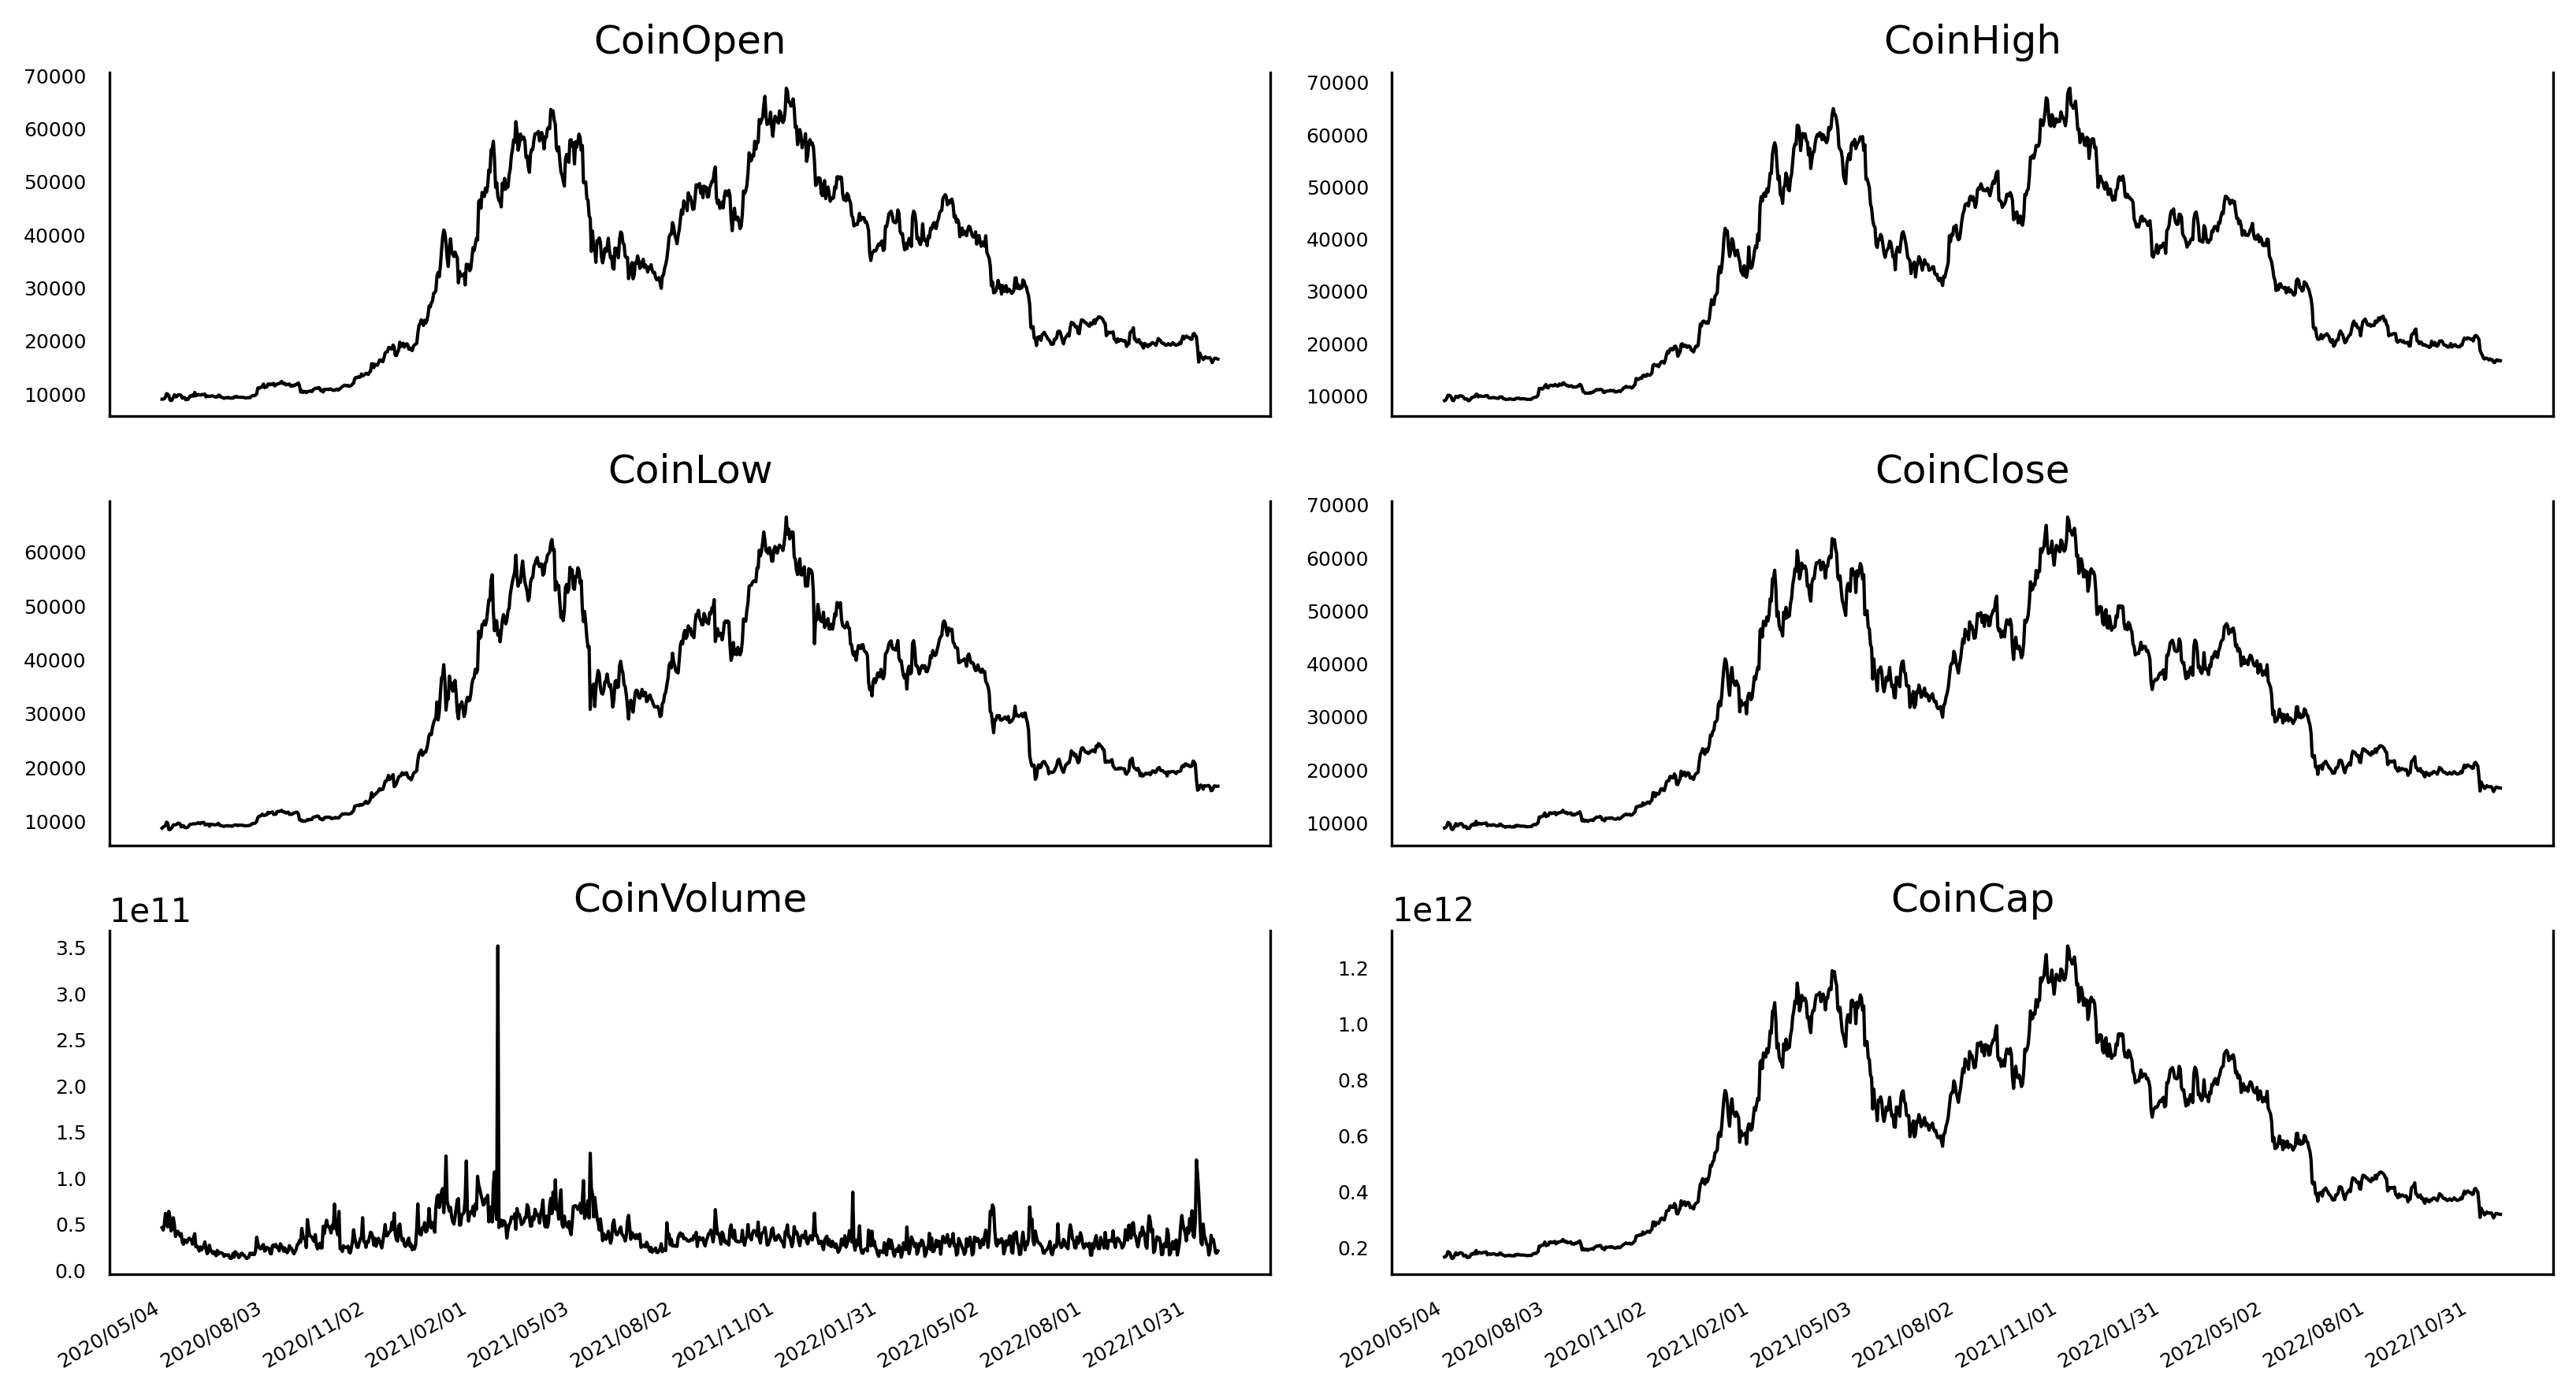

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = df[df.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(df.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0,938,91), xticklabels=x_date)
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('Bitcoin_figures/CH09_F02_peixeiro.png', dpi=300)

In [6]:
target = df['CoinClose']
exog = df[['CoinOpen', 'CoinHigh', 'CoinLow', 'CoinVolume', 'CoinCap']]

In [7]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.486996879940301
p-value: 0.5399337098655169


In [8]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -31.50427486277576
p-value: 0.0


In [9]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        print([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
p = range(2,3,1)
d = 1
q = range(2,3, 1)
P = range(0,1, 1)
D = 0
Q = range(0,1, 1)
s = 365

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
parameters_list

[(2, 2, 0, 0)]

In [11]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 1, 1)
D = 0
Q = range(0, 1, 1)
s = 365

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)


16

In [12]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

[(0, 0, 0, 0), 1542.9486454816542]
[(0, 1, 0, 0), 676.9782657464523]
[(0, 2, 0, 0), 677.6176677699353]
[(0, 3, 0, 0), 687.1122282772881]
[(1, 0, 0, 0), 674.3773012089189]
[(1, 1, 0, 0), 675.4885372641941]
[(1, 2, 0, 0), 702.2057375886552]
[(1, 3, 0, 0), 685.6825145100905]
[(2, 0, 0, 0), 675.5176147501838]
[(2, 1, 0, 0), 677.6344207345317]
[(2, 2, 0, 0), 705.2452234421585]
[(2, 3, 0, 0), 679.8299972926336]
[(3, 0, 0, 0), 677.5793447824528]
[(3, 1, 0, 0), 679.6332689755195]
[(3, 2, 0, 0), 710.3145063285635]
[(3, 3, 0, 0), 674.9623879765973]


,"(p,q,P,Q)",AIC
0,"(1, 0, 0, 0)",674.377301
1,"(3, 3, 0, 0)",674.962388
2,"(1, 1, 0, 0)",675.488537
3,"(2, 0, 0, 0)",675.517615
4,"(0, 1, 0, 0)",676.978266
5,"(3, 0, 0, 0)",677.579345
6,"(0, 2, 0, 0)",677.617668
7,"(2, 1, 0, 0)",677.634421
8,"(3, 1, 0, 0)",679.633269
9,"(2, 3, 0, 0)",679.829997


In [14]:
target_train = target[:200]
exog_train = exog[:200]

# result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
# result_df

In [13]:
best_model = SARIMAX(target_train, exog_train, order=(1,1,0), seasonal_order=(0,0,0,365), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              CoinClose   No. Observations:                  200
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -330.189
Date:                Wed, 15 Feb 2023   AIC                            674.377
Time:                        10:29:33   BIC                            697.430
Sample:                             0   HQIC                           683.708
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CoinOpen   -2.381e-05      0.000     -0.188      0.851      -0.000       0.000
CoinHigh      -0.0015   5.28e-05    -27.934      0.000      -0.002      -0.001
CoinLow       -0.0003   6.45e-05     -3.989      0.0

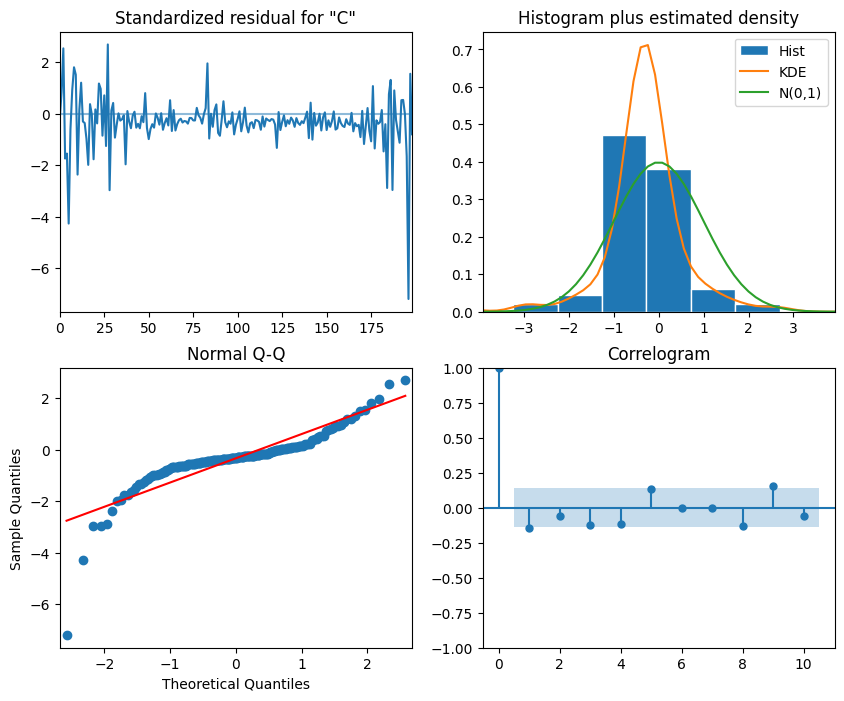

In [14]:
best_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('Bitcoin_figures/CH09_F05_peixeiro.png', dpi=300)

In [15]:
residuals = best_model_fit.resid

pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

pvalue['lb_pvalue']

1     0.926824
2     0.964063
3     0.923277
4     0.949596
5     0.979794
6     0.931947
7     0.966666
8     0.983597
9     0.983254
10    0.989412
Name: lb_pvalue, dtype: float64

In [16]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(1,1,0), seasonal_order=(0,0,0,365), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [24]:
len(target)-14

924

In [17]:
target_train = target[:924]
target_test = target[924:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
924,16618.20,16353.37,16344.676825
925,16884.61,16618.20,16625.236579
926,16669.44,16884.61,16890.888561
927,16687.52,16669.44,16665.120622
928,16697.78,16687.52,16688.517434
929,16711.55,16697.78,16699.161461
930,16291.83,16711.55,16712.285704
931,15787.28,16291.83,16283.538313
932,16189.77,15787.28,15776.870262
933,16610.71,16189.77,16199.509833


In [18]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

1.17954644426454 1.184530834972489


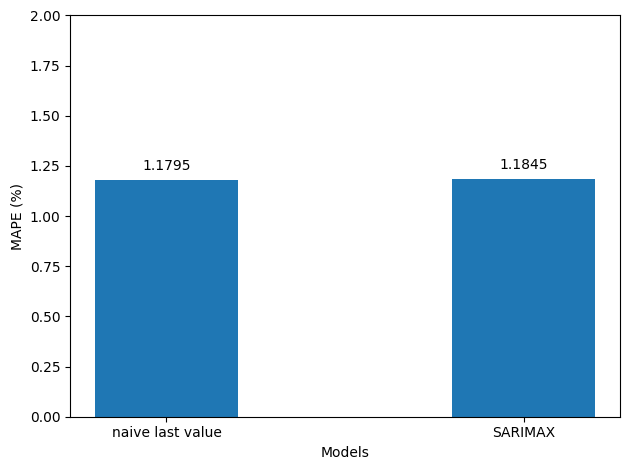

In [20]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 2)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,4)), ha='center')

plt.tight_layout()

plt.savefig('Bitcoin_figures/CH09_F06_peixeiro.png', dpi=400)